1    6048
0    3884
Name: y, dtype: int64
(9932, 18)
(9932, 1)
(7945, 18) (1987, 18)
(7945, 1) (1987, 1)
X_data # of null values for each predictor:
Age                   1339
Diastolic BP          1281
Poverty index         1339
Race                  1339
Red blood cells       1339
Sedimentation rate     513
Serum Albumin         1339
Serum Cholesterol     1339
Serum Iron            1339
Serum Magnesium       1339
Serum Protein         1339
Sex                   1339
Systolic BP           1282
TIBC                  1339
TS                    1339
White blood cells      298
BMI                   1339
Pulse pressure        1280
dtype: int64

y_data # of null values for the prediction:
y    0
dtype: int64
Index(['Age', 'Diastolic BP', 'Poverty index', 'Race', 'Red blood cells',
       'Sedimentation rate', 'Serum Albumin', 'Serum Cholesterol',
       'Serum Iron', 'Serum Magnesium', 'Serum Protein', 'Sex', 'Systolic BP',
       'TIBC', 'TS', 'White blood cells', 'BMI', 'Pulse pressure'],

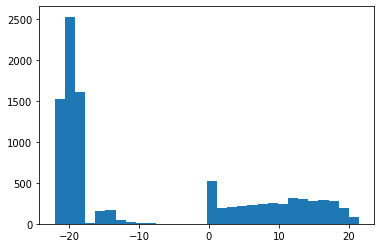

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor


from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.impute import KNNImputer

np.random.seed(109)

X_data = pd.read_csv('NHANESI_X.csv')
y_data = pd.read_csv('NHANESI_y.csv')

X_data = X_data.drop('Unnamed: 0', axis = 1)
y_data = y_data.drop('Unnamed: 0', axis = 1)

plt.hist(x=y_data.values, bins=30)

y_data['y'] = (abs(y_data['y'])>=18)*1

print(y_data['y'].value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2,  random_state = 109, shuffle=True, stratify=y_data['y']
)

print(X_data.shape)
print(y_data.shape)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

X_data.head()

y_data.head()

print("X_data # of null values for each predictor:")
print(X_data[X_data.isnull().any(axis=1)].count())
print("\ny_data # of null values for the prediction:")
print(y_data[y_data.isnull().any(axis=1)].count())

print(X_data.columns)
print(y_data.columns)



#X_data_dropped = X_data.dropna()
#y_data_dropped = y_data.dropna()
combined = pd.concat([X_data, y_data], axis = 1)
print(combined.shape)

combined_dropped = combined.dropna()

print(combined_dropped.shape)

X_data_dropped = combined_dropped[['Age', 'Diastolic BP', 'Poverty index', 'Race', 'Red blood cells',
       'Sedimentation rate', 'Serum Albumin', 'Serum Cholesterol',
       'Serum Iron', 'Serum Magnesium', 'Serum Protein', 'Sex', 'Systolic BP',
       'TIBC', 'TS', 'White blood cells', 'BMI', 'Pulse pressure']]
y_data_dropped = combined_dropped[['y']]

print(X_data_dropped.shape)
print(y_data_dropped.shape)


#knn imputer.fit
#choose number of transmitter


# impute X_data with KNN imputer, n_neighbors = 1

imputer = KNNImputer(n_neighbors=1)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.fit_transform(X_test)
# print(imputer_result)
# print(type(imputer_result))

# turn it into a dataframe, rename columns
X_train_impute = pd.DataFrame(X_train_imputed, columns = X_data.columns)
X_test_impute = pd.DataFrame(X_test_imputed, columns = X_data.columns)

y_train = pd.DataFrame(y_train.values, columns = y_data.columns)
y_test = pd.DataFrame(y_test.values, columns = y_data.columns)

train_imputed = pd.concat([X_train_impute, y_train], axis = 1)
test_imputed = pd.concat([X_test_impute, y_test], axis = 1)

train_imputed.head()

X_train_impute.columns

train_sex = X_train_impute['Sex'].subtract(1)
X_train_impute['Sex'] = train_sex

test_sex = X_test_impute['Sex'].subtract(1)
X_test_impute['Sex'] = test_sex

train_race = X_train_impute['Race'].subtract(1)
X_train_impute['Race'] = train_race

test_race = X_test_impute['Race'].subtract(1)
X_test_impute['Race'] = test_race

X_train_impute.head()



# Baseline KNN regression model on dropped data
baseline_kNN_model = KNeighborsClassifier(n_neighbors=len(X_train_impute)).fit(X_train_impute,y_train.values.ravel())
    
y_pred = baseline_kNN_model.predict(X_test_impute)

baseline_kNN_model_accuracy = mean_squared_error(y_pred,y_test)
print(baseline_kNN_model_accuracy)

# Logistic regression model on dropped data
logit_base = LogisticRegression(max_iter=10000).fit(X_train_impute,y_train.values.ravel())
y_pred = logit_base.predict(X_test_impute)

logit_base_test_accuracy = accuracy_score(y_pred,y_test)
print(logit_base_test_accuracy)

## Single Decision Tree (Depth Chose via Cross-Val)

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

depths = list(range(1, 51))

def calc_meanstd(X_train, y_train, depths):
    train_scores = []
    cvmeans = []
    cvstds = []
    
    for depth in depths:
        dtree = DecisionTreeClassifier(max_depth=depth)
        dtree.fit(X_train, y_train)
        train_score = dtree.score(X_train, y_train)
        scores = cross_val_score(dtree, X_train, y_train, cv=5)
        train_scores.append(train_score)
        cvmeans.append(scores.mean())
        cvstds.append(scores.std())
        
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores = calc_meanstd(X_train_impute, y_train.values.ravel(), depths)


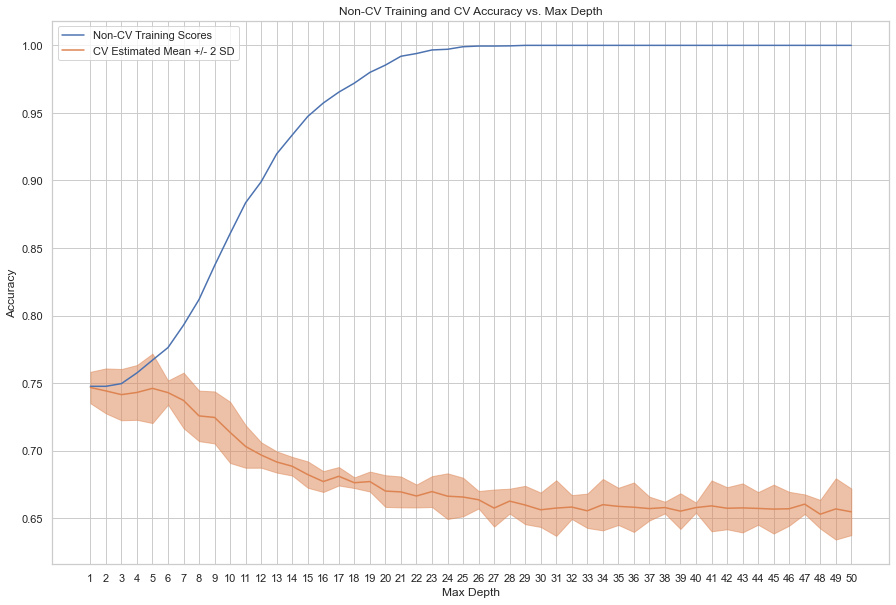

In [17]:
import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

plt.figure(figsize=(15,10))
plt.plot(depths, train_scores, label="Non-CV Training Scores")
plt.plot(depths, cvmeans, label="CV Estimated Mean +/- 2 SD")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, color="C1", alpha=0.5)
plt.legend()
plt.title("Non-CV Training and CV Accuracy vs. Max Depth")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths);

In [27]:
dtree_5 = DecisionTreeClassifier(max_depth=5).fit(X_train_impute, y_train.values.ravel())
best_cv_tree_train_score = dtree_5.score(X_train_impute, y_train.values.ravel())
best_cv_tree_test_score = dtree_5.score(X_test_impute, y_test)
display((best_cv_tree_train_score, best_cv_tree_test_score))
                                        

(0.7670232850849591, 0.7458480120785104)

## Decision Trees with Bagging: 

In [89]:
def bagger(n_trees: int, tree_depth: int,  random_seed=0) -> (pd.DataFrame, pd.DataFrame, list):
    """A function that takes as 
    
    Inputs:
      n_tres
      tree_depth 
      a random_seed (default =0)
    
    Returns:
      bagging_train dataframe (as described above)
      bagging_test dataframe (as described above)
      bagging_models every trained model for each bootstrap (you will need this in Q3.2)
    """
    # your code here
    
    bagging_train_df = pd.DataFrame()
    bagging_test_df = pd.DataFrame()
    bagging_models = []
    
    for i in range(n_trees):
        boot = train_imputed.sample(frac=1, replace=True)
        X_train_boot = boot.iloc[:, boot.columns != "y"].values
        y_train_boot = boot["y"].values
        
        dtree = DecisionTreeClassifier(max_depth=tree_depth, random_state=random_seed)
        dtree.fit(X_train_boot, y_train_boot)
        
        bagging_train_df[f"bootstrap model {i + 1}'s prediction"] = dtree.predict(X_train_impute)
        bagging_test_df[f"bootstrap model {i + 1}'s prediction"] = dtree.predict(X_test_impute)
        bagging_models.append(dtree)
    
    return bagging_train_df, bagging_test_df, bagging_models

In [161]:
tree_depth = 26
model_count = 115

bagging_train_df, bagging_test_df, bagging_models = bagger(n_trees=model_count, tree_depth=tree_depth)
bagging_train_df["Aggregated Output"] = bagging_train_df.mode(axis=1)
bagging_test_df["Aggregated Output"] = bagging_test_df.mode(axis=1)

train_correct = (bagging_train_df["Aggregated Output"] == y_train.values.ravel()) 
bagging_accuracy_train = train_correct.sum() / train_correct.size

test_correct = (bagging_test_df["Aggregated Output"] == y_test.values.ravel())
bagging_accuracy_test = test_correct.sum() / test_correct.size

print(f"Bagging Model Train Accuracy: {bagging_accuracy_train}") 
print(f"Bagging Model Test Accuracy: {bagging_accuracy_test}") 

Bagging Model Train Accuracy: 0.9035871617369414
Bagging Model Test Accuracy: 0.7312531454453951


In [162]:
def running_predictions(prediction_dataset: np.ndarray, targets: np.ndarray) -> np.ndarray:
    
    n_trees = prediction_dataset.shape[1]
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    running_conclusions = running_percent_1s > 0.5
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    return np.mean(running_correctnesss, axis=0)


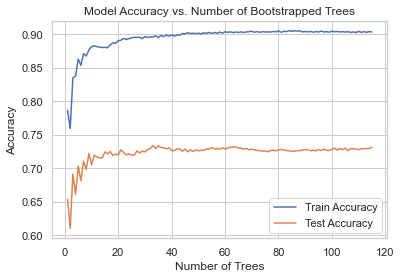

In [163]:
train_score = running_predictions(bagging_train_df[bagging_train_df.columns[:-1]].to_numpy(), y_train.values.ravel())
test_score = running_predictions(bagging_test_df[bagging_test_df.columns[:-1]].to_numpy(), y_test.values.ravel())

num_trees = list(range(1, model_count + 1))

plt.plot(num_trees, train_score, label = "Train Accuracy")
plt.plot(num_trees, test_score, label = "Test Accuracy")
plt.legend()
plt.title("Model Accuracy vs. Number of Bootstrapped Trees")
plt.ylabel("Accuracy")
plt.xlabel("Number of Trees")
ylim = plt.ylim()

